In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from  matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import pickle

In [2]:
warnings.filterwarnings('ignore')

## Загрузка датасетов

In [3]:
train = pd.read_csv('train.csv', index_col='id')
train

,lat,lon,score
id,,,
0,56.228300,43.945535,0.080523
1,56.834244,53.141543,0.104424
2,45.042299,41.990170,0.067615
3,59.849408,30.387762,0.088038
4,59.839643,30.304308,0.099686
...,...,...,...
3079,55.674584,37.279505,0.531557
3080,55.784909,49.188791,0.101631
3081,55.118828,61.462996,0.125265


In [4]:
test = pd.read_csv('test.csv', index_col='id')
test.sort_values(by='lat')

,lat,lon
id,,
3147,43.413594,39.934144
3218,43.426709,39.926265
3170,43.431560,39.922401
3570,43.432724,39.916454
3135,43.433924,39.926360
...,...,...
3612,60.050416,30.380888
3914,60.051748,30.362746
3490,60.054499,30.328812


In [5]:
test.duplicated().mean()

0.0

In [6]:
features = pd.read_csv('features.csv')

In [7]:
print(features.duplicated().mean())
print(features.transpose().duplicated().mean())

0.0
0.0


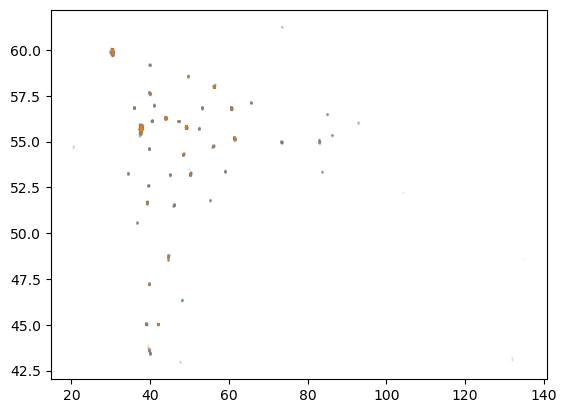

In [8]:
plt.scatter(train['lon'], train['lat'], s=0.5, alpha=0.1)
plt.scatter(test['lon'], test['lat'],s=0.5, alpha=0.1)
plt.show()

In [9]:
dummy = DummyRegressor()
-cross_val_score(dummy, train[['lat', 'lon']], train['score'], scoring='neg_mean_absolute_error', cv=5).mean()

0.07580974787706832

## Генерация признаков

In [10]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(features[['lat', 'lon']], features.drop(['lat', 'lon'], axis=1))

KNeighborsRegressor(n_neighbors=10, weights='distance')

In [11]:
new_train = train.join(pd.DataFrame(knn.predict(train[['lat', 'lon']]), index = train.index), on= 'id')

new_test = test.join(pd.DataFrame(knn.predict(test[['lat', 'lon']]), index = test.index), on= 'id')

In [12]:
X = new_train.drop('score', axis=1)
y = new_train['score']

## Удаление коррелирующих признаков

<AxesSubplot:>

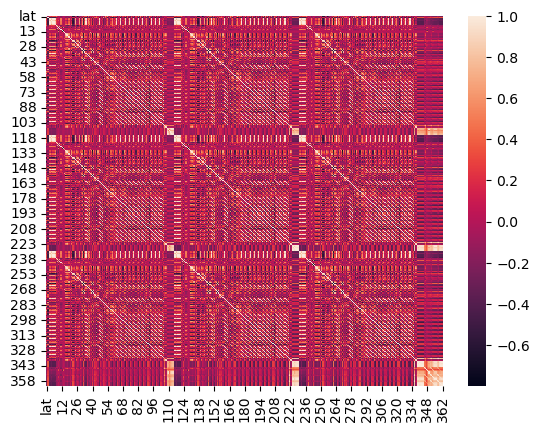

In [13]:
corr_matrix = abs(pd.DataFrame(X)).corr()
sns.heatmap(corr_matrix)

In [14]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column]>0.9)]
X.drop(to_drop, axis=1, inplace=True)

<AxesSubplot:>

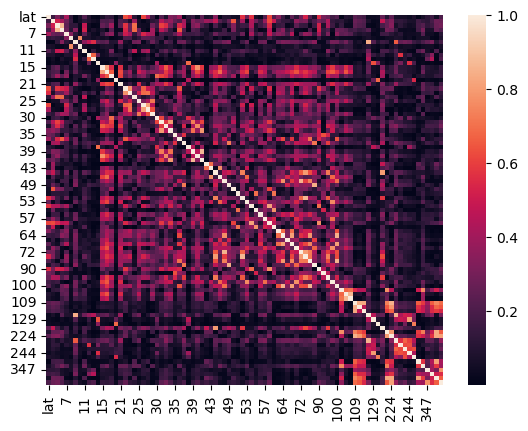

In [15]:
sns.heatmap(X.corr().abs())

## Удаление малозначимых признаков

In [16]:
tree = DecisionTreeRegressor(random_state=12345)
tree.fit(X, y)
imp = pd.Series(tree.feature_importances_, index = X.columns)
to_drop = imp[imp<0.01].index
X.drop(to_drop, axis=1, inplace=True)

In [17]:
new_test = new_test[X.columns]

In [18]:
new_test.to_csv('new_test.csv')
new_train.to_csv('new_train.csv')

## Обучение модели и подбор гп

In [19]:
gb = GradientBoostingRegressor(verbose=False)
dict = {'n_estimators': [100, 200],
        'max_depth': [2, 4],
        'learning_rate': [0.05, 0.1, 0.3],
        'loss': ['squared_error', 'absolute_error']}
gs = GridSearchCV(gb, param_grid = dict, scoring = 'neg_mean_absolute_error', cv=3)
gs.fit(X, y)

print(gs.best_estimator_)
print(gs.best_score_)

GradientBoostingRegressor(learning_rate=0.05, loss='absolute_error',
                          max_depth=4, n_estimators=200, verbose=False)
-0.057783014989163134


In [20]:
model = gs.best_estimator_
model.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, loss='absolute_error',
                          max_depth=4, n_estimators=200, verbose=False)

In [21]:
pickle.dump(model, open('model.pkl', 'wb'))

<BarContainer object of 31 artists>

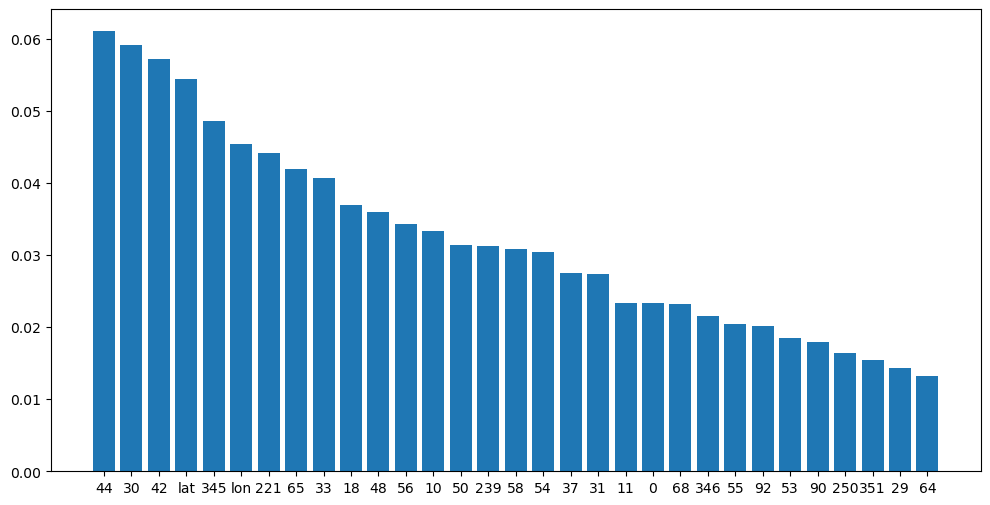

In [22]:
imp = pd.Series(model.feature_importances_, index = [str(el) for el in list(X.columns)]).sort_values(ascending=False)

fig, ax = plt.subplots(figsize = (12, 6))

ax.bar(imp.index, imp)